# Om Gaikwad
## HW3

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')



# Step 1 - Data Preparation
Load the Titanic.csv file and examine a sample of the data. Notice that the dataset contains both
categorical and numerical features.
1. Address any missing values by imputing them with the feature's mean across the dataset.
2. For this assignment, select a subset of the data including the independent variables: 'pclass', 'sex',
'age', and 'sibsp', and the dependent variable 'survived'.
3. Ensure that 'survived' is a binary variable coded as 1 (yes) or 0 (no).
4. Split the data into training and test sets, using an 80/20 split.

In [16]:
pd.options.mode.chained_assignment = None
file_path = '/Users/omiee/Documents/GitHub/AAI-595/Assignments/HW3/Titanic-1.csv'
titanic = pd.read_csv(file_path)

titanic.info()
titanic.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1309 non-null   int64  
 1   pclass      1309 non-null   object 
 2   survived    1309 non-null   int64  
 3   name        1309 non-null   object 
 4   sex         1309 non-null   object 
 5   age         1046 non-null   float64
 6   sibsp       1309 non-null   int64  
 7   parch       1309 non-null   int64  
 8   ticket      1309 non-null   object 
 9   fare        1308 non-null   float64
 10  cabin       295 non-null    object 
 11  embarked    1307 non-null   object 
 12  boat        486 non-null    object 
 13  body        121 non-null    float64
 14  home.dest   745 non-null    object 
dtypes: float64(3), int64(4), object(8)
memory usage: 153.5+ KB


,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [17]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

print("Original unique values:", titanic['pclass'].unique())
print("Original unique values:", titanic['sex'].unique())

Original unique values: ['1st' '2nd' '3rd']
Original unique values: ['female' 'male']


In [18]:
# Fill missing values in 'age' with the average age
titanic['age'].fillna(titanic.age.mean(), inplace=True)

# Convert categorical features to numeric
titanic['pclass'] = label_encoder(titanic['pclass'])
titanic['sex'] = label_encoder(titanic['sex'])

# Discretization
titanic = titanic[['pclass', 'sex', 'age', 'sibsp', 'survived']]
titanic['survived'] = titanic['survived'].apply(lambda x: 1 if int(x) == 1 else 0)

# Select relevant columns
selected_columns = ['pclass', 'sex', 'age', 'sibsp', 'survived']
titanic = titanic[selected_columns]

print("Encoded unique values:", titanic['pclass'].unique())
print("Encoded unique values:", titanic['sex'].unique())



Encoded unique values: [0 1 2]
Encoded unique values: [0 1]


In [19]:
# Split the data into 80% training and 20% test sets
train_data, test_data = train_test_split(titanic, test_size=0.2, random_state=42, stratify=titanic['survived'])

train_data.head()

,pclass,sex,age,sibsp,survived
999,2,0,29.881135,0,1
392,1,0,24.000000,1,1
628,2,0,11.000000,4,0
1165,2,1,25.000000,0,0
604,2,0,16.000000,0,1


# Step 2 - Data Processing and Initial Analysis

1. Recognize that the 'age' attribute is continuous. As discussed in our class, decision trees are
typically applied to categorical features. Utilize the steps outlined in the provided Jupyter
notebook to discretize 'age' using quantile binning.
2. Compute the information gain to determine the optimal first split in the decision tree.

In [20]:
# Apply quantile binning to the 'age' column (choosing 5 bins for discretization)
train_data['age'] = QuantileBinning(train_data['age'], 10)
test_data['age'] = QuantileBinning(test_data['age'], 10)

train_data.head()

# define your entropy function and information gain function
def entropy(class_labels):
    total = len(class_labels)
    class_counts = class_labels.value_counts().to_dict()

    entropy_value = 0
    for label in class_counts:
        p = class_counts[label] / total
        entropy_value -= p * np.log2(p)
    return entropy_value

def information_gain(S, subsets):
    entropy_S = entropy(S)
    total_len = sum(len(subset) for subset in subsets)
    weighted_entropy = sum(len(subset) / total_len * entropy(subset) for subset in subsets)
    gain = entropy_S - weighted_entropy
    return gain

# Calculate Information Gain for each feature in the training set
target_variable = train_data['survived']
features = ['pclass', 'sex', 'age', 'sibsp']

info_gains = {}
for feature in features:
    subsets = [target_variable[train_data[feature] == val] for val in train_data[feature].unique()]
    info_gains[feature] = information_gain(target_variable, subsets)

print("Information Gain for each feature:")
print(info_gains)

max_feature = max(info_gains, key=info_gains.get)
print("\nFirst split: ", max_feature)

Information Gain for each feature:
{'pclass': np.float64(0.06460212978122204), 'sex': np.float64(0.196100832731124), 'age': np.float64(0.02061576401356191), 'sibsp': np.float64(0.03371829138587601)}

First split:  sex


# Step 3

1. Employ sklearn to train a decision tree model, setting the maximum number of leaf nodes to 20
and the random_state to your student id number. (Please apply it to all the rest questions)
2. Visualize the complete tree. Note that your tree's structure and size may vary from the example.
3. Implement a function to calculate the accuracy, precision, recall, and F1 score on the test set.

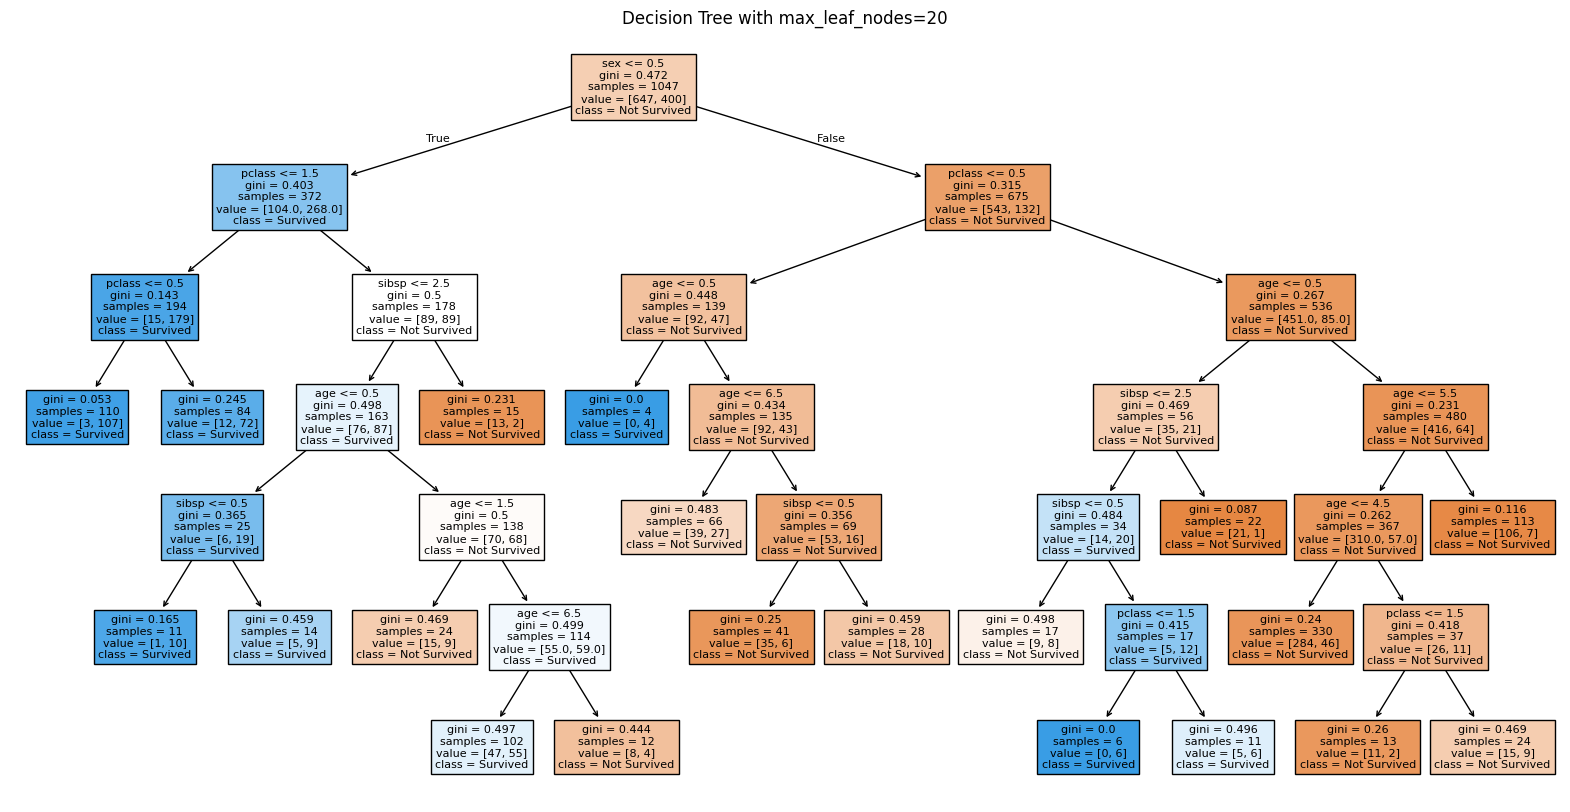

In [21]:
from sklearn.tree import DecisionTreeClassifier, plot_tree 

# Prepare the features and target variables for training
X_train = train_data[['pclass', 'sex', 'age', 'sibsp']]
y_train = train_data['survived']
X_test = test_data[['pclass', 'sex', 'age', 'sibsp']]
y_test = test_data['survived']

# Fit the decision tree model
student_id = 20002350  #Student ID number
clf = DecisionTreeClassifier(max_leaf_nodes=20, random_state=student_id)
clf.fit(X_train, y_train)

# Plot the full decision tree
clf

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=['pclass', 'sex', 'age', 'sibsp'], class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree with max_leaf_nodes=20")
plt.show()



In [22]:
# Define your performance metrics including accuracy, precision, recall and F1-score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, prec, rec, f1

# Evaluate the decision tree on the test set
accuracy, precision, recall, f1 = evaluate_model(clf, X_test, y_test)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8130
Precision: 0.7931
Recall: 0.6900
F1 Score: 0.7380


# Step 4 - Model Optimization
1. Apply GridSearchCV() to identify the optimal max_leaf_nodes parameter, exploring values from
5 to 20, for tree pruning.
2. Plot the pruned tree, which should be more compact than the initially generated tree. Report the
performance. (using metrics in step 3.3, same below for step 5)

Optimal max_leaf_nodes found: 11


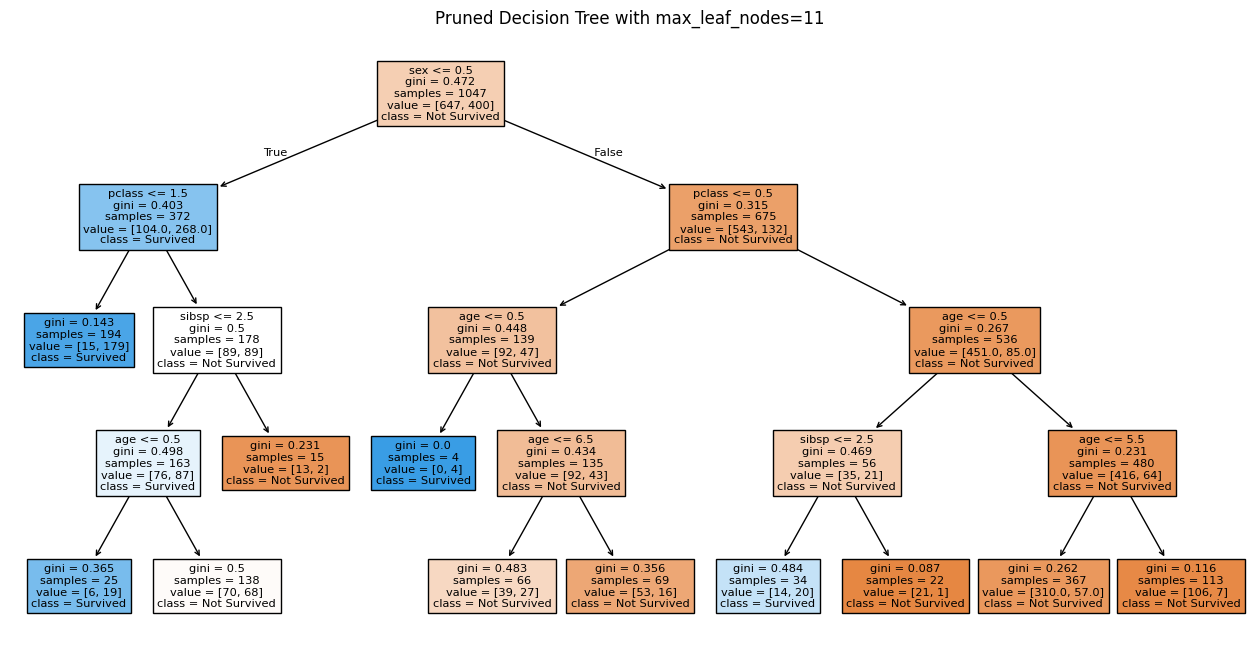

Pruned Tree Performance:
Accuracy: 0.8053
Precision: 0.8182
Recall: 0.6300
F1 Score: 0.7119


In [23]:
from sklearn.model_selection import GridSearchCV

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train) 

# Get the best estimator with the optimal max_leaf_nodes parameter
param_grid = {'max_leaf_nodes': list(range(5, 21))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=student_id), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator with the optimal max_leaf_nodes parameter
best_tree = grid_search.best_estimator_
best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']

print(f"Optimal max_leaf_nodes found: {best_max_leaf_nodes}")
best_tree

# Plot the pruned decision tree
plt.figure(figsize=(16, 8))
plot_tree(best_tree, feature_names=['pclass', 'sex', 'age', 'sibsp'], class_names=['Not Survived', 'Survived'], filled=True)
plt.title(f"Pruned Decision Tree with max_leaf_nodes={best_max_leaf_nodes}")
plt.show()

# Evaluate the pruned tree on the test set
accuracy_pruned, precision_pruned, recall_pruned, f1_pruned = evaluate_model(best_tree, X_test, y_test)

print(f"Pruned Tree Performance:")
print(f"Accuracy: {accuracy_pruned:.4f}")
print(f"Precision: {precision_pruned:.4f}")
print(f"Recall: {recall_pruned:.4f}")
print(f"F1 Score: {f1_pruned:.4f}")


# Step 5 - Advanced Modeling

1. Replicate Steps 3 and 4 to construct two additional decision tree models with varying parameters,
such as the maximum depth and splitting criteria.
2. Use majority vote to create an ensemble learning model that combines the three decision trees
model we trained in the step 4 and step 5.1.
3. Use the RandomFOrestClassifier() function to train a random forest using the optimal tree size
you found in step 4. You can set n_estimator as 50. Compare the performance of your random
forest and your ensembled model.


In [24]:

# Model 2: Using "entropy" criterion and limiting max_depth
tree_model_2 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=student_id)
tree_model_2.fit(X_train, y_train)

tree_model_3 = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=student_id)
tree_model_3.fit(X_train, y_train)

# Evaluate both models on the test set
acc2, prec2, rec2, f1_2 = evaluate_model(tree_model_2, X_test, y_test)
acc3, prec3, rec3, f1_3 = evaluate_model(tree_model_3, X_test, y_test)

print("Model 2 (entropy, max_depth=5):")
print(f"Accuracy: {acc2:.4f}, Precision: {prec2:.4f}, Recall: {rec2:.4f}, F1: {f1_2:.4f}")

print("\nModel 3 (gini, max_depth=4):")
print(f"Accuracy: {acc3:.4f}, Precision: {prec3:.4f}, Recall: {rec3:.4f}, F1: {f1_3:.4f}")


Model 2 (entropy, max_depth=5):
Accuracy: 0.7977, Precision: 0.7640, Recall: 0.6800, F1: 0.7196

Model 3 (gini, max_depth=4):
Accuracy: 0.8053, Precision: 0.8182, Recall: 0.6300, F1: 0.7119


In [25]:
def ensemble_vote(models, X):

    # Collect predictions from all models
    predictions = np.array([model.predict(X) for model in models])
    
    # Sum the predictions across models (since classes are 0 and 1)
    votes = np.sum(predictions, axis=0)
    
    # Majority vote: if 2 or more models vote for class 1, output 1, else 0
    ensemble_predictions = np.where(votes >= 2, 1, 0)

    return ensemble_predictions

# Use the defined function to get predictions from the ensemble of the three trees
models = [best_tree, tree_model_2, tree_model_3]
ensemble_predictions = ensemble_vote(models, X_test)

# Evaluate ensemble model
acc_ens = accuracy_score(y_test, ensemble_predictions)
prec_ens = precision_score(y_test, ensemble_predictions)
rec_ens = recall_score(y_test, ensemble_predictions)
f1_ens = f1_score(y_test, ensemble_predictions)

print("Ensemble Model Performance:")
print(f"Accuracy: {acc_ens:.4f}")
print(f"Precision: {prec_ens:.4f}")
print(f"Recall: {rec_ens:.4f}")
print(f"F1 Score: {f1_ens:.4f}")

Ensemble Model Performance:
Accuracy: 0.8053
Precision: 0.8182
Recall: 0.6300
F1 Score: 0.7119


In [26]:


# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest 
rf_model = RandomForestClassifier(n_estimators=50, max_leaf_nodes=best_max_leaf_nodes, random_state=student_id)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")



Random Forest Performance:
Accuracy: 0.8321
Precision: 0.8333
Recall: 0.7000
F1 Score: 0.7609


In [27]:

# Compare to Ensemble
print("\nComparison with Ensemble:")
print(f"Ensemble Accuracy: {acc_ens:.4f} vs Random Forest Accuracy: {acc_rf:.4f}")
print(f"Ensemble F1 Score: {f1_ens:.4f} vs Random Forest F1 Score: {f1_rf:.4f}")


Comparison with Ensemble:
Ensemble Accuracy: 0.8053 vs Random Forest Accuracy: 0.8321
Ensemble F1 Score: 0.7119 vs Random Forest F1 Score: 0.7609
